In [4]:
# display, transform, read, split ...
import numpy as np
import matplotlib.pyplot as plt
import splitfolders

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import  Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Dropout is a regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
from tensorflow.keras.layers import Dropout, BatchNormalization
# BatchNormalization normalizes the inputs of each layer to improve training speed and stability.
from tensorflow.keras.regularizers import l2

In [5]:
# Add normalization to the ImageDataGenerator for train, test, and validation
# 'preprocess_input' is typically a function that normalizes or standardizes the input images.
# This helps in maintaining the same data distribution during training and evaluation.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# define classes name
class_names = ['Fear','Happy','Sad']

In [7]:
splitfolders.ratio("./dataset", output="./data-split", seed=1337, ratio=(0.7, 0.2, 0.1), group_prefix=None, move=False)


In [8]:
# Using the ImageDataGenerator instance (train_datagen) to create a data generator for the training dataset
train_generator = train_datagen.flow_from_directory(
    directory="./data-split/train",  # Path to the directory containing the training dataset
    classes=class_names,             # List of class names (subdirectory names) to use for classification
    target_size=(224, 224),          # Resize all images to 224x224 pixels
    batch_size=32,                   # Number of images to return in each batch
    class_mode="categorical",        # The type of classification problem ('categorical' indicates multi-class classification)
)

Found 364 images belonging to 3 classes.


In [9]:
# test data
test_generator = test_datagen.flow_from_directory( 
    directory="./data-split/test", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical", 

)

Found 56 images belonging to 3 classes.


In [10]:
# validation data
valid_generator = val_datagen.flow_from_directory( 
    directory="./data-split/val/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical",
     
)

Found 105 images belonging to 3 classes.


In [11]:
# ResNet50 model
resnet_50 = ResNet50(
    include_top=False,  # Exclude the fully connected (dense) layers on top of the network.
    weights='imagenet', # Load weights pre-trained on the ImageNet dataset.
    input_shape=(224, 224, 3) # Specify the input shape of the images: 224x224 pixels with 3 color channels (RGB).
)
# This means that the weights of these layers will not be updated during training.
for layer in resnet_50.layers:
    layer.trainable = False
    x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = layers.Dense(3, activation='softmax')(x)

# Create the final model
# The inputs are from ResNet50, and the outputs are the predictions
model = Model(inputs=resnet_50.input, outputs=predictions)

In [12]:
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
    
    return model.fit(train_generator,
                     validation_data=valid_generator,
                     epochs=epochs,
                     batch_size=batch_size,
                     callbacks=[early_stopping, reduce_lr])

In [13]:
# launch the training
model_history = trainModel(model = model, epochs = 50, optimizer = "Adam")

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.4363 - loss: 1.5693 - val_accuracy: 0.6857 - val_loss: 0.7785 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7733 - loss: 0.5985 - val_accuracy: 0.6952 - val_loss: 0.8102 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.8745 - loss: 0.3353 - val_accuracy: 0.6952 - val_loss: 0.8399 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.8922 - loss: 0.2933 - val_accuracy: 0.6857 - val_loss: 0.8137 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9202 - loss: 0.1838 - val_accuracy: 0.6762 - val_loss: 0.8556 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9418 - loss: 0.1391 - val_accuracy: 0.6857 - val_loss: 0.8828 - learning_rate: 0.0010


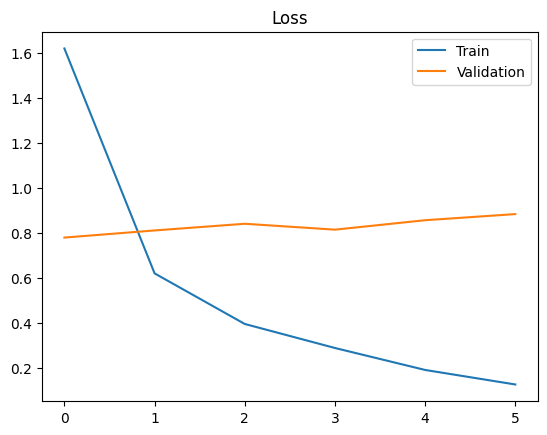

In [14]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

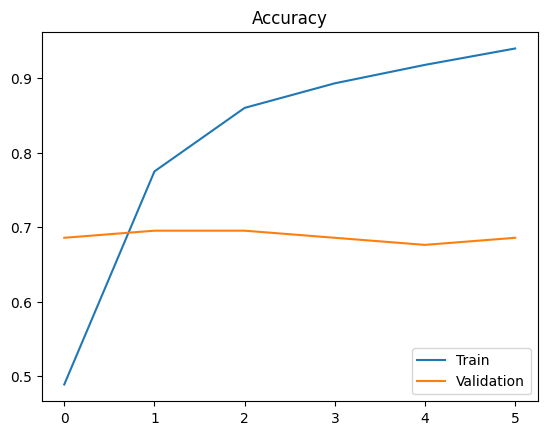

In [15]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print("The best accuracy is: ", test_acc*100)
print("The test loss is: ", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6696 - loss: 0.8432
The best accuracy is:  66.07142686843872
The test loss is:  0.9158301949501038
